# <center> <b> One Class Image Classification </b></center> <br>
Classify if the given image is an apple.

### **Work Flow:**  <br>
1. Importing packages and reading the dataset
2. Data Pipeline
3. ResNet50 : To featurize the image's
4. PCA : To get the most important features
5. Model Training
6. Predicting output of test data
7. Evaluating the model

### 1. Importing packages and reading the dataset

In [1]:
!pip install Augmentor

In [60]:
#Importing packages
from google.colab import drive
import os
from tqdm import tqdm
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score , recall_score , f1_score

import Augmentor
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
#mounting gdrive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#getting number of data points in the original datase

info_train = []

for root, __, files in os.walk("/content/drive/MyDrive/Train_images"):
  for f in files:
      if f.endswith(".jpg") or f.endswith(".png"):
         info_train.append(root + "/" + f)

In [5]:
#displaying the number of datapoints
print("Number of images in train data : " ,len(info_train))

Number of images in train data :  8


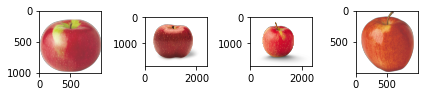

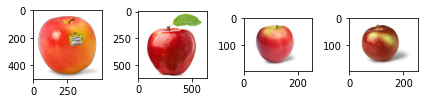

In [6]:
#displaying the images

#counter to display 4 images per row
c = 0

for root, __, files in os.walk("/content/drive/MyDrive/Train_images"):
  for f in files:
    if f.endswith(".jpg") or f.endswith(".PNG") or f.endswith(".png"):
         c = c+1
         if(c>8):
           break
         plt.subplot(2,4,c)
         img  = mpimg.imread(root + "/" + f)
         plt.imshow(img)
         if (c%4==0):
           plt.tight_layout()
           plt.show()
         

In [7]:
#creating a test directory to evaluate how well the model performce
info_test = []
i = 1
for root, __, files in os.walk("/content/drive/MyDrive/Test_images"):
  for f in files:
      if f.endswith(".jpg") or f.endswith(".PNG") or f.endswith(".png"):
         info_test.append(root + "/" + f)

In [8]:
#displaying the number of images in the test data
print("Number of images in test data : " ,len(info_test))

Number of images in test data :  6


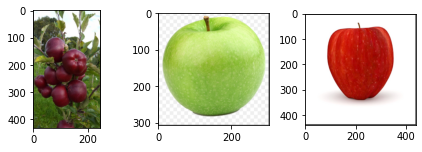

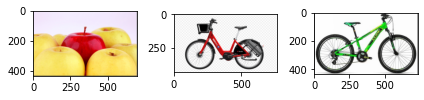

In [9]:
#displaying the images

#counter to display 3 images per row
c = 1

for root, __, files in os.walk("/content/drive/MyDrive/Test_images"):
  for f in files:
    if f.endswith(".jpg") or f.endswith(".PNG") or f.endswith(".png"):
         plt.subplot(2,3,c)
         img  = mpimg.imread(root + "/" + f)
         plt.imshow(img)
         if (c==3) or (c==6):
           plt.tight_layout()
           plt.show()
         c = c+1

### 2. Data Pipeline

In [10]:
# defining the data pipline

p = Augmentor.Pipeline("/content/drive/MyDrive/Train_images")
  
# Defining augmentation parameters 
p.flip_left_right(0.5)
p.rotate(0.3, 10, 10)
p.skew(0.4, 0.5)
p.resize(probability=1.0, width=224, height=224)
p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
p.flip_top_bottom(probability=1)

#creating a sample of 1000 images
p.sample(1000) 

Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 8 image(s) found.
Output directory set to /content/drive/MyDrive/Train_images/output.

Processing <PIL.Image.Image image mode=P size=224x224 at 0x7F63132E6690>: 100%|██████████| 1000/1000 [00:54<00:00, 18.42 Samples/s]


In [11]:
#getting the total number of data points in train data after data agumentation
info_train_new = []
i = 1
for root, __, files in os.walk("/content/drive/MyDrive/Train_images"):
  for f in files:
      if f.endswith(".jpg") or f.endswith(".png"):
         info_train_new.append(root + "/" + f)

In [12]:
print("Number of images in train data after data augumentation : " , len(info_train_new))

Number of images in train data after data augumentation :  1008


### 3. ResNet50 : To featurize the image's

In [13]:
# getting the featurized data for each image

image_size = 224

#list that stores the complete path of the images
train_img_paths = info_train_new
test_img_paths = info_test

#function to convert images to its vector representation
def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in tqdm(img_paths)]
    img_array = np.array([img_to_array(img) for img in imgs])
    output = preprocess_input(img_array)
    return(output)

#conversion of image to vector
X_train = read_and_prep_images(train_img_paths)
X_test = read_and_prep_images(test_img_paths)

  0%|          | 0/1008 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 6/6 [00:00<00:00, 133.15it/s]


In [14]:
#getting the optimum vector representation of the images

resnet_model = ResNet50(input_shape=(image_size, image_size, 3), weights="imagenet", include_top=False, pooling='avg')  # Since top layer is the fc layer used for predictions

X_train = resnet_model.predict(X_train)
X_test = resnet_model.predict(X_test)

In [15]:
# standardising the image vectors
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

### 4. PCA : To get the most important features

In [16]:
#getting the top 480 features
pca = PCA(n_components=480, whiten=True)
pca = pca.fit(X_train)
print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

Explained variance percentage = 0.98


In [17]:
#storing train and test features 
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

X_train_df.to_csv("/content/drive/MyDrive/final_features.csv" , index = False)
X_test_df.to_csv("/content/drive/MyDrive/final_features_test.csv" , index = False)

### 5. Model Training

In [18]:
#reading the data
train = pd.read_csv("/content/drive/MyDrive/final_features.csv")
test = pd.read_csv("/content/drive/MyDrive/final_features_test.csv")

In [19]:
#displaying train data
train.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479
0,-0.458575,0.262861,-0.296225,-0.111580,0.621664,-0.796679,-0.517982,0.142106,-0.095527,2.24318,2.052796,-0.917386,-0.007684,1.203495,1.582920,2.903206,-3.409500,-3.129820,1.571032,-2.931853,0.941592,0.634188,2.328000,2.633437,0.138660,-0.999849,-1.799698,-1.996300,3.453120,-0.302809,-1.337302,-0.123814,-0.200143,-1.842570,-0.373290,0.966619,0.207780,-0.539406,0.126859,-1.261637,...,-0.783713,1.149336,0.127480,0.270663,0.607192,0.492939,0.718618,1.079482,-1.554902,-0.324891,-0.057243,-0.284969,0.122017,-0.519472,0.033232,0.425629,-0.517359,-0.848883,1.108048,-0.806637,-0.055252,0.176472,-0.291034,0.488255,0.924663,0.290506,-0.347974,0.180377,-0.775760,-0.524684,-0.101553,-0.161544,-0.214484,0.767791,-0.790876,-0.092000,0.766946,0.821399,-0.545092,-0.258403
1,0.537280,-0.345335,-0.701561,0.332648,0.019934,-0.062553,-0.277964,-0.524660,0.198234,3.19600,1.323291,0.813259,1.787825,1.787585,2.413182,2.920128,-3.405735,-2.427045,2.121664,-1.960549,0.918978,0.341058,1.706245,3.777006,-1.202887,0.627641,-2.754806,-1.415105,2.607313,-0.058599,1.225848,-0.968359,-1.157082,-2.538914,-0.384736,0.103448,-0.117256,0.443637,0.776529,0.372630,...,-1.220585,0.340543,0.856987,-0.484489,0.883575,0.170922,-0.726873,-0.372974,0.295144,-0.794651,-1.062579,0.230017,0.470748,0.240242,-0.173771,0.516971,-0.228662,0.095891,-0.666906,0.537493,0.030129,-0.104153,-0.388722,0.691574,0.058295,-0.714629,0.262879,-0.380160,-0.142376,-0.967920,0.403776,0.923722,-0.279322,0.092937,1.059522,0.898565,0.391234,0.469458,-0.839548,-0.108792


In [20]:
#displaying test data
test.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479
0,-0.313008,-0.214592,0.068377,0.530407,0.421031,-0.881067,-0.299235,0.702457,2.509588,1.164330,0.029220,2.306496,1.064966,0.722250,-0.578889,-0.319507,-0.532600,-4.626292,1.134015,-2.399279,0.415931,0.520323,1.417747,3.111882,2.472087,1.620357,-1.281926,-2.929400,2.001835,0.768749,0.377546,4.500383,4.117024,-2.827223,-1.149259,-0.502788,-1.310960,-2.668410,0.537171,-1.782660,...,5.025899,-2.647216,7.547984,-7.097021,-0.327515,-4.179913,-3.983771,-4.226390,-0.249756,-7.975751,14.134810,0.870529,1.027929,-0.141334,-4.788179,-0.608951,-6.530028,1.494728,0.753798,-4.260082,-0.881704,-0.398208,3.822441,0.917149,-3.929598,-0.354137,-0.946454,-6.059688,4.421089,-1.181018,8.850279,-5.911097,3.785511,6.821130,-0.801533,0.849391,3.457485,-6.894380,11.157006,-6.015586
1,-0.530613,0.448405,-0.138884,0.276531,0.541128,-0.791537,-0.238883,-0.448747,0.415296,3.214833,1.807663,0.031734,1.100964,1.116548,2.666664,3.106807,-3.531768,-2.954289,3.931199,-2.340543,1.482878,2.995128,2.584235,4.324153,1.609443,0.041351,-2.069530,-0.989844,3.755949,1.372243,-1.372638,-2.332956,0.403408,-0.634101,0.832436,-1.118877,-1.489415,-0.356172,-0.862892,-1.884055,...,-5.121475,-5.062573,-3.689090,0.209980,-2.564773,2.212603,-5.166816,4.101757,-0.888267,-7.799810,-0.822742,0.038936,2.854023,-2.241346,-6.665371,1.597189,-2.583110,-0.582968,3.545726,-0.825482,-0.243037,1.822246,-8.036520,1.523384,4.361080,-2.264160,-0.313817,3.610186,2.292225,4.479781,-2.153448,5.757534,3.843231,-3.800152,1.220873,-3.934249,3.932316,-3.718278,-2.054544,1.069809


In [34]:
#training OneClassSVM model

#obtained nu by evaluating the models performace on the test set and train set with various nu values
oc_svm_clf = svm.OneClassSVM(kernel = "sigmoid" , nu=0.005)
oc_svm_clf.fit(train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale',
            kernel='sigmoid', max_iter=-1, nu=0.005, shrinking=True, tol=0.001,
            verbose=False)

In [41]:
#predicting the labelof test data
oc_svm_preds = oc_svm_clf.predict(test)

In [36]:
#converting the numerical value to string value
#if model predicted 1, then replace it with "apple" else "not apple"
labels = ["apple" if i == 1 else "not apple" for i in oc_svm_preds ]

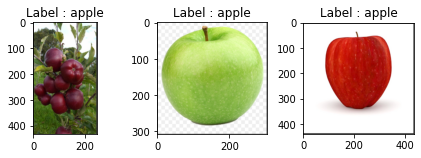

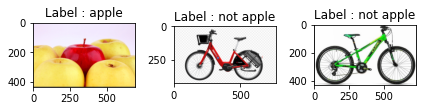

In [37]:
#displaying the test images with the predicted label

#counter to display 3 images per row
c = 1

for root, __, files in os.walk("/content/drive/MyDrive/Test_images"):
  for f in files:
    
      if f.endswith(".jpg") or f.endswith(".PNG") or f.endswith(".png"):
         plt.subplot(2,3,c)
         img  = mpimg.imread(root + "/" + f)
         plt.title("Label : " + str(labels[c-1]))
         plt.imshow(img)
         if (c%3==0):
           plt.tight_layout()
           plt.show()
         c = c+1

### 6. Evaluating the model

In [38]:
#getting number of data points classified as not apple (-1) and apple (1)
train_model = Counter(oc_svm_clf.predict(train).tolist())
test_model =  Counter(oc_svm_clf.predict(test).tolist())

In [55]:
#getting the predicted value
y_train = np.ones(len(info_train_new))
y_train_pred = oc_svm_clf.predict(train)

y_test = np.array([1,1,1,1,-1,-1])
y_test_pred = oc_svm_preds

In [57]:
#model performance

print("Train Precisison score : " , precision_score(y_train , y_train_pred))
print("Test Precisison score : " , precision_score(y_test , y_test_pred))

print("\n\nTrain Recall score : " , recall_score(y_train , y_train_pred))
print("Test Recall score : " , recall_score(y_test , y_test_pred))

print("\n\nTrain F1 score : " , f1_score(y_train , y_train_pred))
print("Test F1 score : " , f1_score(y_test , y_test_pred))

Train Precisison score :  1.0
Test Precisison score :  1.0


Train Recall score :  0.9007936507936508
Test Recall score :  1.0


Train F1 score :  0.9478079331941546
Test F1 score :  1.0
